# Compressed Sensing Testing

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as scimg
from skimage import io
import cvxpy as cvx
import scipy.sparse
import utils # JML: import utils for 2d_operator_dct to save memory 

In [99]:
x = np.sort(np.random.uniform(0,10,15))
y = 3 + 0.2*x + 0.1*np.random.randn(len(x))

In [100]:
# Sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394*np.pi*t) + np.sin(3266*np.pi*t)
yt = spfft.dct(y, norm='ortho')

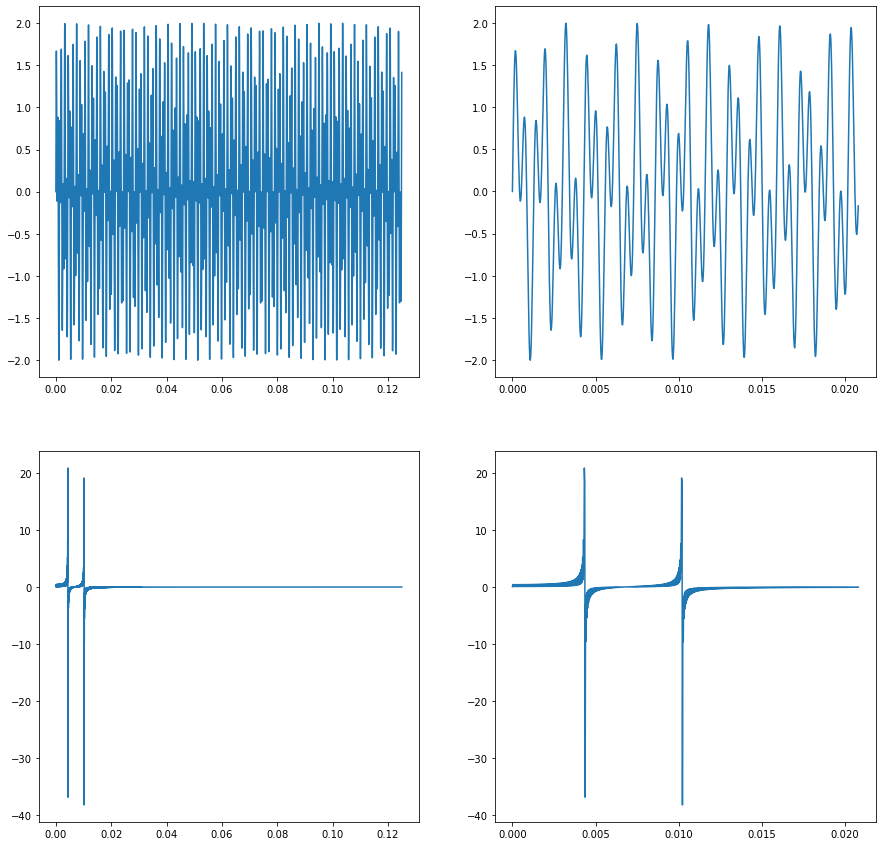

In [101]:
plt.figure(figsize=(15,15));
plt.subplot(221);plt.plot(t,y)
plt.subplot(222);plt.plot(t[0:5000//6],y[0:5000//6])
plt.subplot(223);plt.plot(t,yt)
plt.subplot(224);plt.plot(t[0:5000//6],yt[0:5000//6])

### extract small smaple of signal

In [102]:
m = 500 
# random sample of indice
ri = np.random.choice(n, m, replace=False) 
ri.sort()
t2 = t[ri]
y2 = y[ri]

(0, 0.02)

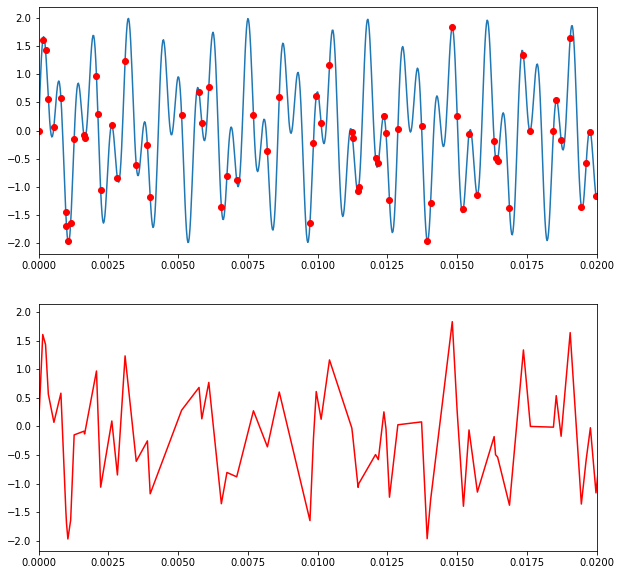

In [103]:
plt.figure(figsize=(10,10))
plt.subplot(211); 
plt.plot(t[0:5000//6],y[0:5000//6],t2,y2,'ro')
plt.xlim(0,0.02)
plt.subplot(212); plt.plot(t2,y2,'r')
plt.xlim(0,0.02)

### create idct matrix operator

In [104]:
A = spfft.idct(np.identity(n),norm='ortho',axis=0)
A = scipy.sparse.csr_matrix(A[ri])

### L1 optimization

In [ ]:
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx,1))
constrains = [A@vx == y2]
prob = cvx.Problem(objective, constrains)
result = prob.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.704e-23  -0.000e+00  +3e+04  1e+00  1e-02  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +1.282e+02  +1.283e+02  +1e+04  9e-01  5e-03  5e-01  1e+00  0.6287  9e-02   1  1  1 |  0  0
 2  +1.684e+02  +1.686e+02  +9e+03  7e-01  4e-03  6e-01  9e-01  0.4671  6e-01   1  1  0 |  0  0
 3  +2.135e+02  +2.138e+02  +5e+03  4e-01  2e-03  4e-01  5e-01  0.8362  4e-01   1  0  0 |  0  0
 4  +2.679e+02  +2.680e+02  +2e+03  2e-01  1e-03  2e-01  2e-01  0.7886  3e-01   1  0  0 |  0  0
 5  +3.144e+02  +3.144e+02  +1e+03  1e-01  5e-04  1e-01  1e-01  0.6190  2e-01   1  1  1 |  0  0
 6  +3.438e+02  +3.438e+02  +5e+02  5e-02  2e-04  5e-02  5e-02  0.6718  2e-01   1  1  1 |  0  0
 7  +3.575e+02  +3.575e+02  +3e+02  2e-02  1e-04  3e-02  3e-02  0.5876  2e-01   1  1  1 |  0  0
 8  +3.661e+02  +3.661e+02  +1e+02  1e-02  5e-

### reconstruct signal

In [ ]:
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221);plt.plot(yt[0:500])
plt.subplot(222);plt.plot(x[0:500],'r')
plt.subplot(223);plt.plot(y[0:500])
plt.subplot(224);plt.plot(sig[0:500],'r')

## Reconstruct of Image Example

In [ ]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig1 = io.imread('test.jpeg') # read in grayscale
Xorig = io.imread('test.jpeg', as_gray=True) # read in grayscale
X = scimg.zoom(Xorig, 0.04)
ny,nx = X.shape

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(131);plt.imshow(Xorig)
plt.subplot(132);plt.imshow(X)
plt.subplot(133);plt.imshow(dct2(X))

In [ ]:
k = round(nx * ny * 0.6)
ri = np.random.choice(nx * ny, k, replace=False)
b = X.T.flat[ri]

### create dct matrix operator using kron (memory errors for large ny*nx)

In [ ]:
# A = np.kron(spfft.idct(np.identity(nx), norm='ortho', axis=0),
#    spfft.idct(np.identity(ny), norm='ortho', axis=0))
# A = A[ri,:] # same as phi times kron
A = utils.dct_operator_2D(nx, ny) # a virtual function in which you need to compute the 2D dct using the scipy.sparse.LinearOperator

###   L1 optimization

In [ ]:
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == b] # Replace A*vx by A.dot(vx). If A is a linear operator then the memory will be very small. 
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

### reconstruct image

In [ ]:
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = (idct2(Xat))

In [ ]:
plt.imshow(Xa)